# Module imports

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from livelossplot import PlotLossesKerasTF

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(1234)

import datasets
import losses
import cnns
import model

# Model selection

In [5]:
"""
Select model type to be trained
cnns.ResNet50 - Residual Net model
cnns.SENet50 - Squeeze Net model
cnns.VGG16 - VGG16 model
"""
#get_cnns = cnns.ResNet50
#get_cnns = cnns.SENet50
get_cnns = cnns.VGG16

#Initialise dataset with model type
dataset = datasets.MEBeauty(get_cnns()[0])

# Model training

In [3]:
"""
Training metrics to evaluate model performance
Check 'losses.py' file for implementation
"""
metrics = [
    tf.keras.metrics.KLDivergence(),
    losses.EarthMoversDistance(),
    losses.MeanAbsoluteError(dataset.n),
    losses.RootMeanSquaredError(dataset.n),
    losses.PearsonCorrelation(dataset.n),
    losses.MeanAbsoluteError(dataset.n, mode="std"),
    losses.RootMeanSquaredError(dataset.n, mode="std"),
    losses.PearsonCorrelation(dataset.n, mode="std"),
    losses.MeanAbsoluteError(dataset.n, mode="skew"),
    losses.RootMeanSquaredError(dataset.n, mode="skew"),
    losses.PearsonCorrelation(dataset.n, mode="skew")
]

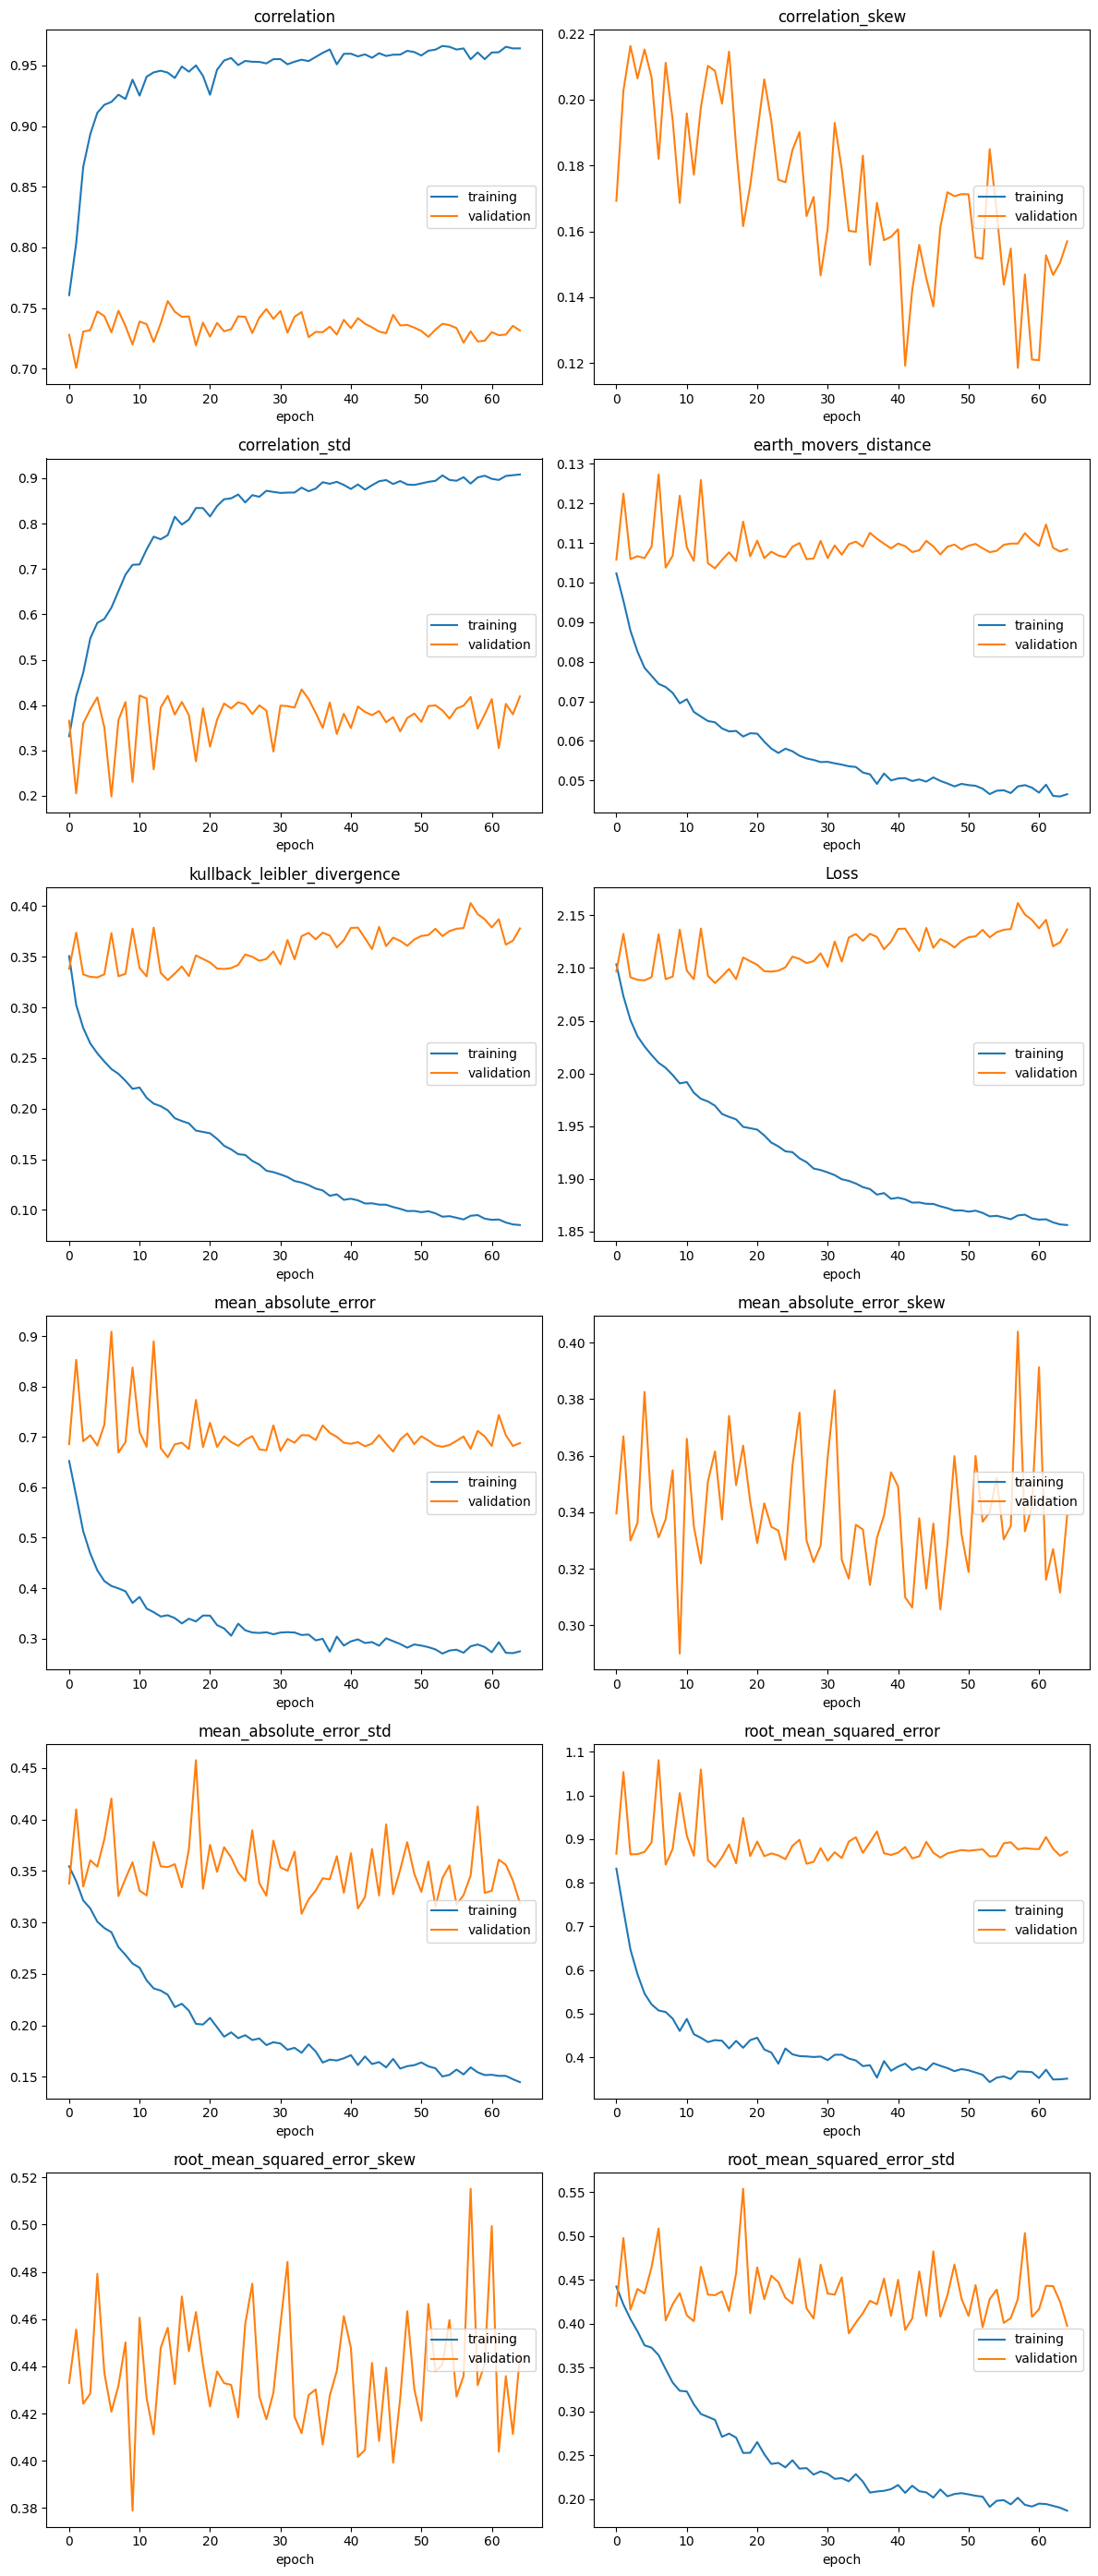

correlation
	training         	 (min:    0.761, max:    0.966, cur:    0.964)
	validation       	 (min:    0.701, max:    0.756, cur:    0.731)
correlation_skew
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:    0.119, max:    0.216, cur:    0.157)
correlation_std
	training         	 (min:    0.331, max:    0.908, cur:    0.908)
	validation       	 (min:    0.199, max:    0.434, cur:    0.419)
earth_movers_distance
	training         	 (min:    0.046, max:    0.102, cur:    0.047)
	validation       	 (min:    0.104, max:    0.127, cur:    0.108)
kullback_leibler_divergence
	training         	 (min:    0.085, max:    0.351, cur:    0.085)
	validation       	 (min:    0.327, max:    0.403, cur:    0.378)
Loss
	training         	 (min:    1.856, max:    2.103, cur:    1.856)
	validation       	 (min:    2.086, max:    2.162, cur:    2.137)
mean_absolute_error
	training         	 (min:    0.270, max:    0.652, cur:    0.275)
	validation       	 (m

In [6]:
"""
Ensemble training loop
"""
y_pred_total = np.zeros(dataset.test.y.shape)
time_total = 0 #Total time required to train the model
k = 2 #The number of models to be trained (if building an ensemble)
m = model.Model(get_cnns, dataset) #Initialise model

for i in range(k):
    m.construct(supress=True)
    """
    Compile model with a given loss function
    cce - Categorical Cross Entropy
    l2 - 2-Norm loss
    emd - Earth Mover's Distance
    """
    m.compile("cce", metrics=metrics)
    y_pred, time = m.train(
        iteration=i,
        monitor="val_mean_absolute_error", #Early stopping metric
        save=True,
        predict=False)
    y_pred_total += y_pred 
    time_total += time

y_pred_total /= k

# Results

In [16]:
"""
Function to output the metric results on the test set
into a latex table format
"""
def results(y_test, y_pred, end="	", supress=False):
    if not supress: 
        print(f"{tf.keras.metrics.KLDivergence()(y_test, y_pred):.4}", end=end)
        print(f"{metrics[1](y_test, y_pred):.3}")

    res = 0
    for i in range(2,len(metrics)):
        if (i-1) % 3 == 0:
            r = metrics[i](y_test, y_pred).numpy()[0][0]
            if not supress:
                print(f"{str(r)[0:5]}", end=end)
                print()
        else:
            r = metrics[i](y_test, y_pred).numpy()
            if i == 2:
                res = r
            if not supress: print(f"{str(r)[0:5]}", end=end)

    return res

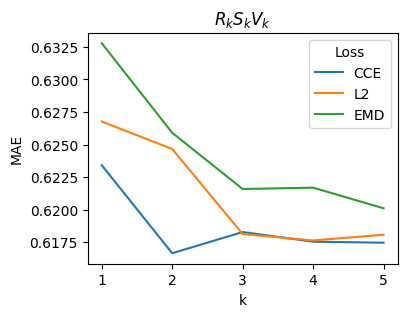

In [33]:
"""
The following code produces a graph of the evaluation
of the averaged prediction on the MEBeauty test set 
across a range of ensemble sizes
"""
import matplotlib.pyplot as plt
import pickle
with open("./MEBeauty/resnet50/(14, 14, 1024)/test.pkl", "rb") as f:
    y_test = pickle.load(f).y

x = np.arange(1,6)

plt.figure(figsize=(4,3))
for l in ["cce","l2","emd"]:
    y = []
    for k in x:
        y_pred_total = np.zeros_like(y_test)

        for i in range(k):
            for bb in ["resnet50","senet50","vgg16"]:
                path = "./MEBeauty/"+bb+"/"
                y_pred_total += np.load(path+l+f"/y_pred_{i}.npy")

        y_pred_total /= 3*k
        y.append(results(y_test, y_pred_total, end=" & ", supress=True))

    plt.plot(x,y,label=l.upper())

plt.title("$R_k$$S_k$$V_k$")
plt.ylabel("MAE")
plt.xlabel("k")
plt.xticks(x)
plt.legend(loc="upper right", title="Loss")
#plt.savefig("C:/Users/ugail/Downloads/rsv.png", bbox_inches='tight', dpi=500)
plt.show()

In [28]:
"""
The following code averages 2 predictions from each trained
model type (trained using cce loss) and produces an evaluation
table
"""
k = 2
l = "cce"

import pickle
with open(path+"(14, 14, 1024)/test.pkl", "rb") as f:
    y_test = pickle.load(f).y

y_pred_total = np.zeros_like(y_test)

for path in ["./MEBeauty/vgg16/",
             "./MEBeauty/senet50/",
             "./MEBeauty/resnet50/"]:
    for i in range(k):
        y_pred_total += np.load(path+l+f"/y_pred_{i}.npy")

y_pred_total /= k*3

results(y_test, y_pred_total, end=" & ")

0.3235 & 0.104
0.654 & 0.839 & 0.766 & 
0.380 & 0.465 & 0.388 & 
0.373 & 0.471 & 0.231 & 


0.65404224